<a href="https://colab.research.google.com/github/k3larra/Codex/blob/main/Codex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iris Classification with PyTorch

This notebook demonstrates how to build, train, and evaluate a simple feed-forward neural network on the classic Iris dataset using PyTorch.
It includes data preprocessing, model definition, training with validation, and final evaluation on a hold-out test set.

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

batch_size = 16
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(96, 24, 30)

In [3]:
class IrisNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        return self.model(x)

model = IrisNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

IrisNet(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [4]:
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(device)
            labels = labels.to(device)
            logits = model(features)
            loss = loss_fn(logits, labels)
            preds = torch.argmax(logits, dim=1)
            total_loss += loss.item() * labels.size(0)
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)
    return total_loss / total_examples, total_correct / total_examples

epochs = 100
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_examples = 0

    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(features)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        running_loss += loss.item() * labels.size(0)
        running_correct += (preds == labels).sum().item()
        running_examples += labels.size(0)

    train_loss = running_loss / running_examples
    train_acc = running_correct / running_examples
    val_loss, val_acc = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}')

history

Epoch 001 | Train Loss: 1.0834 | Train Acc: 0.333 | Val Loss: 1.0779 | Val Acc: 0.333
Epoch 010 | Train Loss: 0.9078 | Train Acc: 0.833 | Val Loss: 0.8867 | Val Acc: 0.792
Epoch 020 | Train Loss: 0.5838 | Train Acc: 0.781 | Val Loss: 0.5522 | Val Acc: 0.792
Epoch 030 | Train Loss: 0.4039 | Train Acc: 0.875 | Val Loss: 0.3846 | Val Acc: 0.833
Epoch 040 | Train Loss: 0.3130 | Train Acc: 0.906 | Val Loss: 0.3044 | Val Acc: 0.875
Epoch 050 | Train Loss: 0.2352 | Train Acc: 0.906 | Val Loss: 0.2477 | Val Acc: 0.875
Epoch 060 | Train Loss: 0.1790 | Train Acc: 0.948 | Val Loss: 0.1970 | Val Acc: 0.875
Epoch 070 | Train Loss: 0.1507 | Train Acc: 0.948 | Val Loss: 0.1799 | Val Acc: 0.917
Epoch 080 | Train Loss: 0.1316 | Train Acc: 0.958 | Val Loss: 0.1477 | Val Acc: 0.958
Epoch 090 | Train Loss: 0.1105 | Train Acc: 0.958 | Val Loss: 0.1358 | Val Acc: 0.958
Epoch 100 | Train Loss: 0.0817 | Train Acc: 0.990 | Val Loss: 0.1358 | Val Acc: 0.958


{'train_loss': [1.0833639899889629,
  1.0685708324114482,
  1.0565440654754639,
  1.0334710081418355,
  1.0186281104882557,
  0.9979914228121439,
  0.9806936681270599,
  0.9526820182800293,
  0.9267247120539347,
  0.9077809154987335,
  0.8689133624235789,
  0.850443015495936,
  0.8227820098400116,
  0.788243850072225,
  0.7461473345756531,
  0.7175352076689402,
  0.6934666335582733,
  0.6302854716777802,
  0.629837840795517,
  0.5838380455970764,
  0.5493184427420298,
  0.5257822076479594,
  0.5411427219708761,
  0.4938661952813466,
  0.48527272045612335,
  0.45535847047964734,
  0.43756010631720227,
  0.42982080082098645,
  0.41623083253701526,
  0.40391480922698975,
  0.39282235006491345,
  0.3803184578816096,
  0.37573501467704773,
  0.35225222011407215,
  0.33534857134024304,
  0.3423255557815234,
  0.3158157443006833,
  0.3253330240646998,
  0.3289855072895686,
  0.3130253652731578,
  0.28752170006434125,
  0.2926059067249298,
  0.27540556341409683,
  0.27405127386252087,
  0.2661

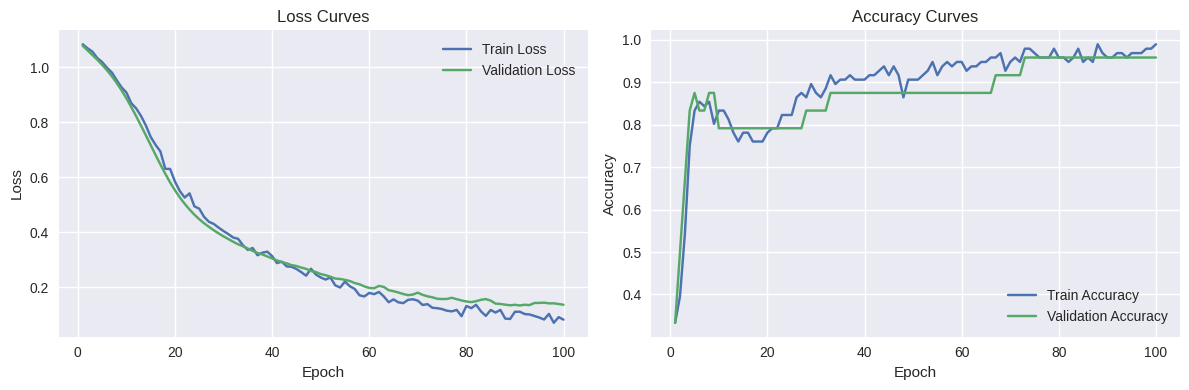

In [5]:
%matplotlib inline
epochs_range = range(1, epochs + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(epochs_range, history['train_loss'], label='Train Loss')
axes[0].plot(epochs_range, history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss Curves')

axes[1].plot(epochs_range, history['train_acc'], label='Train Accuracy')
axes[1].plot(epochs_range, history['val_acc'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy Curves')
plt.tight_layout()
plt.show()

In [6]:
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.3f}')

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor.to(device))
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

print('Classification Report:')
print(classification_report(y_test, predictions, target_names=iris.target_names))
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions))

Test Loss: 0.1389
Test Accuracy: 0.933
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


## Next steps
- Experiment with different network architectures (more layers, different activations).
- Adjust optimization hyperparameters such as learning rate, batch size, and epochs.
- Try data augmentation techniques or cross-validation to further evaluate model robustness.